In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['figure.figsize'] = 10, 6

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_path = '/content/gdrive/My Drive/idiap_models/NN_blinds/'

In [ ]:
train = np.load(data_path + 'train.npy',allow_pickle='TRUE')
valid = np.load(data_path + 'valid.npy',allow_pickle='TRUE')

In [ ]:
!nvidia-smi

Mon Dec 21 11:50:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

In [ ]:
train_x, train_y = train[:,:-2], train[:,-2:]
valid_x, valid_y = valid[:,:-2], valid[:,-2:]

In [ ]:
def mse_loss(t1, t2):
    return torch.sum((t1-t2)**2) / t1.numel()

def mse(y, yhat):
    """
    Computes MSE - our models loss
    """
    return np.sum((np.array(y) - np.array(yhat))**2) / len(y)

def mae(y, yhat):
    """
    Computes Mean Absolute Error
    """
    return np.sum(np.abs(np.array(y) - np.array(yhat))) / len(y)

In [ ]:
BATCH_SIZE = 32

train_X, train_Y = torch.from_numpy(train_x), torch.from_numpy(train_y)
valid_X, valid_Y = torch.from_numpy(valid_x), torch.from_numpy(valid_y)

train_df = TensorDataset(train_X, train_Y)
valid_df = TensorDataset(valid_X, valid_Y)

train_dl = DataLoader(train_df, BATCH_SIZE, shuffle=False)
valid_dl = DataLoader(valid_df, BATCH_SIZE, shuffle=False)


In [ ]:
next(iter(valid_dl))

In [ ]:
NUM_FEATURES = train_x.shape[1]
NUM_LABELS = train_y.shape[1]

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(NUM_FEATURES, 1000)
        self.act1 = nn.ReLU() 
        self.linear2 = nn.Linear(1000, 1000)
        self.act2 = nn.ReLU() 
        self.linear3 = nn.Linear(1000, 1000)
        self.act3 = nn.ReLU() 
        self.linear4 = nn.Linear(1000, NUM_LABELS)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.linear3(x)
        x = self.act3(x)
        x = self.linear4(x)
        return x

In [ ]:
model = SimpleNet().to('cuda')
loss_fn = mse_loss(train_Y.float(),train_Y.float()).to('cuda')
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.000008)

Epoch number: 0, Training loss: 0.167, Validation loss: 0.080 Best so far: 0.080
Epoch number: 10, Training loss: 0.027, Validation loss: 0.027 Best so far: 0.027
Epoch number: 20, Training loss: 0.021, Validation loss: 0.023 Best so far: 0.023
Epoch number: 30, Training loss: 0.017, Validation loss: 0.020 Best so far: 0.020
Epoch number: 40, Training loss: 0.015, Validation loss: 0.019 Best so far: 0.019
Epoch number: 50, Training loss: 0.013, Validation loss: 0.019 Best so far: 0.018
Epoch number: 60, Training loss: 0.013, Validation loss: 0.017 Best so far: 0.017
Epoch number: 70, Training loss: 0.011, Validation loss: 0.017 Best so far: 0.016
Epoch number: 80, Training loss: 0.010, Validation loss: 0.016 Best so far: 0.016
Stopped training since model validation loss didnt imporve after 6 epochs


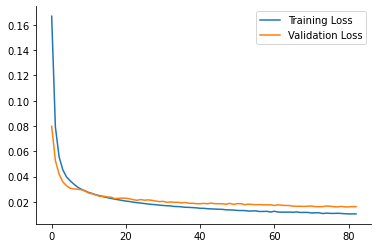

In [ ]:
def fit(num_epochs, model, loss_fn, opt):
    
    epoch_number = []
    train_losses = []
    val_losses = []
    train_losses_per_batch = []
    val_losses_per_batch = []
    best_valid_loss = 100
    early_stopping = 0
    
    for epoch in range(num_epochs):
        model.train()
        for xb,yb in train_dl:
            xb, yb = xb.to('cuda'), yb.to('cuda')
            y_hat = model(xb.float())
            loss = loss_fn(yb, y_hat)
            train_losses_per_batch.append(loss)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.set_grad_enabled(False):
            for val_xb, val_yb in valid_dl:
                val_xb, val_yb = val_xb.to('cuda'), val_yb.to('cuda')
                y_hat = model(val_xb.float())
                val_loss = loss_fn(val_yb, y_hat)
                val_losses_per_batch.append(val_loss)

        train_losses.append(torch.mean(torch.stack(train_losses_per_batch)))
        val_losses.append(torch.mean(torch.stack(val_losses_per_batch)))
        train_losses_per_batch = []
        val_losses_per_batch = []
        epoch_number.append(epoch)

        if val_losses[-1] < best_valid_loss:
            best_valid_loss =  val_losses[-1]
            torch.save(model.state_dict(), data_path + "MLP_state.pth")
            early_stopping = 0
        
        if val_losses[-1] >= best_valid_loss: 
            early_stopping +=1
          
        if early_stopping > 5:
            print("Stopped training since model validation loss didnt imporve after 6 epochs")
            break

        if epoch % 10 == 0:  
            print('Epoch number: %i, Training loss: %.3f, Validation loss: %.3f Best so far: %.3f' % (epoch, train_losses[-1], val_losses[-1], best_valid_loss))

    plt.plot(epoch_number, train_losses, label='Training Loss')
    plt.plot(epoch_number, val_losses, label='Validation Loss')
    plt.legend()
    plt.show()

fit(300, model, mse_loss, opt)